In [1]:
! pip install mlxtend pandas pyfpgrowth efficient-apriori


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import ast

### Data Preparation

In [5]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

# Load the dataset 
data = pd.read_csv(r"C:\Users\User\git\mini-project-ml\Data\cleaned_recipes.csv")

# Preprocess RecipeIngredientParts

data['RecipeIngredientParts'] = data['RecipeIngredientParts'].apply(eval)

# Convert the dataset into transactional format
transactions = data['RecipeIngredientParts'].tolist()

# Display a sample transaction
print("Sample Transaction:", transactions[0])


Sample Transaction: ['blueberries', 'granulated sugar', 'vanilla yogurt', 'lemon juice']


### Apriori Implementation

In [ ]:
import pandas as pd
import ast
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Path to the cleaned dataset
DATA_PATH = "../../data/cleaned_recipes.csv"

def load_and_preprocess_data():
    """
    Load and preprocess the dataset.
    """
    diet_data = pd.read_csv(DATA_PATH)
    # Convert 'RecipeIngredientParts' back to list
    diet_data["RecipeIngredientParts"] = diet_data["RecipeIngredientParts"].apply(ast.literal_eval)
    return diet_data

def generate_association_rules(diet_data, min_support=0.01, min_confidence=0.3):
    """
    Generate frequent itemsets and association rules from the dataset.
    """
    # Generate ingredient transactions
    transactions = diet_data["RecipeIngredientParts"].tolist()

    # Encode transactions
    te = TransactionEncoder()
    ingredient_matrix = te.fit_transform(transactions)
    ingredients_df = pd.DataFrame(ingredient_matrix, columns=te.columns_)

    # Generate frequent itemsets
    frequent_itemsets = apriori(ingredients_df, min_support=min_support, use_colnames=True)

    # Pass `num_itemsets` if required
    try:
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    except TypeError as e:
        if "num_itemsets" in str(e):
            rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence, num_itemsets=len(frequent_itemsets))
        else:
            raise e
    
    # Convert antecedents and consequents to lists for easier processing
    rules["antecedents"] = rules["antecedents"].apply(lambda x: list(x))
    rules["consequents"] = rules["consequents"].apply(lambda x: list(x))

    return rules

def recommend_ingredients(rules, selected_ingredients):
    """
    Recommend additional ingredients based on selected ones.
    """
    matched_rules = rules[rules["antecedents"].apply(lambda x: set(selected_ingredients).issubset(set(x)))]
    
    if matched_rules.empty:
        return []

    recommendations = matched_rules[["consequents", "confidence"]]
    recommendations = recommendations.explode("consequents").groupby("consequents").mean().reset_index()
    recommendations = recommendations.sort_values(by="confidence", ascending=False)

    return recommendations.to_dict(orient="records")

def recommend_recipes_from_recommendations(diet_data, ingredient_recommendations, selected_ingredients, confidence_threshold=0.45, max_recipes=5):
    """
    Recommend recipes based on selected ingredients and additional recommendations with confidence > confidence_threshold,
    limiting the number of recommended recipes to max_recipes.
    """
    # Filter recommended ingredients with confidence > threshold
    high_confidence_ingredients = [
        item["consequents"] for item in ingredient_recommendations if item["confidence"] > confidence_threshold
    ]

    # Flatten the list of high-confidence ingredients
    additional_ingredients = []
    for sublist in high_confidence_ingredients:
        additional_ingredients.extend(sublist)

    # Combine selected ingredients with high-confidence ingredients
    combined_ingredients = selected_ingredients + additional_ingredients

    # Define a function to calculate ingredient match score
    def calculate_match_score(recipe_ingredients, combined_ingredients):
        recipe_set = set(recipe_ingredients)
        combined_set = set(combined_ingredients)
        return len(recipe_set.intersection(combined_set))

    # Calculate match scores for all recipes
    diet_data["MatchScore"] = diet_data["RecipeIngredientParts"].apply(
        lambda x: calculate_match_score(x, combined_ingredients)
    )

    # Filter and sort recipes by match score
    matching_recipes = diet_data[diet_data["MatchScore"] > 0].sort_values(by="MatchScore", ascending=False)

    # Limit to max_recipes
    top_recipes = matching_recipes.head(max_recipes)

    # Return the top recipes
    return top_recipes[["RecipeId", "Name", "Description", "CookTime", "TotalTime", "RecipeIngredientParts"]].to_dict(orient="records")


if __name__ == "__main__":
    # Step 1: Load the data
    diet_data = load_and_preprocess_data()

    # Step 2: Define selected ingredients
    selected_ingredients = ["floor", "milk"]

    # Step 3: Generate association rules
    rules = generate_association_rules(diet_data)

    # Step 4: Generate ingredient recommendations
    ingredient_recommendations = recommend_ingredients(rules, selected_ingredients)

    # Step 5: Recommend recipes with max 5 results
    recommended_recipes = recommend_recipes_from_recommendations(
        diet_data,
        ingredient_recommendations,
        selected_ingredients,
        confidence_threshold=0.45,
        max_recipes=5
    )

    # Print the number of recommended recipes
    print(f"Number of Recommended Recipes: {len(recommended_recipes)}")

    # Print detailed recommended recipes
    print("Recommended Recipes:")
    for recipe in recommended_recipes:
        print(f"- {recipe['Name']} (Cook Time: {recipe['CookTime']} mins)")




Number of Recommended Recipes: 5
Recommended Recipes:
- Savory Cornbread Stuffing (Cook Time: 45 mins)
- The Great Pumpkin Pie Recipe (Cook Time: 65 mins)
- Easy Chicken Poppers (Cook Time: 24 mins)
- Grandma's Pie Dough (Cook Time: 5 mins)
- Suzanne's Rolls (Cook Time: 20 mins)


### Apriori Association Rules Evaluation

In [2]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import ast

# Path to the cleaned dataset
DATA_PATH = "../../data/cleaned_recipes.csv"

def load_and_preprocess_data():
    """
    Load and preprocess the dataset.
    """
    # Load the CSV file
    diet_data = pd.read_csv(DATA_PATH)

    # Convert 'RecipeIngredientParts' back to list format
    diet_data["RecipeIngredientParts"] = diet_data["RecipeIngredientParts"].apply(ast.literal_eval)
    return diet_data

def evaluate_association_rules(diet_data, min_support=0.01, min_confidence=0.3, min_lift=1.0, min_conviction=1.0):
    """
    Generate and evaluate association rules from the diet data.
    """
    # Generate ingredient transactions
    transactions = diet_data["RecipeIngredientParts"].tolist()

    # Encode transactions into a matrix
    te = TransactionEncoder()
    ingredient_matrix = te.fit_transform(transactions)
    ingredients_df = pd.DataFrame(ingredient_matrix, columns=te.columns_)

    # Generate frequent itemsets using apriori algorithm
    frequent_itemsets = apriori(ingredients_df, min_support=min_support, use_colnames=True)

    # Generate association rules based on confidence metric
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence, num_itemsets=len(frequent_itemsets))

    # Filter rules by additional metrics like Lift and Conviction
    rules = rules[(rules['lift'] >= min_lift) & (rules['conviction'] >= min_conviction)]

    return rules

# Example usage
diet_data = load_and_preprocess_data()  # Load your dataset

# Evaluate association rules with desired thresholds
rules_apriori = evaluate_association_rules(diet_data, min_support=0.01, min_confidence=0.3, min_lift=1.0, min_conviction=1.0)

# Display the evaluated rules
print(f"Number of Association Rules: {len(rules_apriori)}")
rules_apriori[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'conviction']]
avg_support_apriori = rules_apriori['support'].mean()
avg_confidence_apriori = rules_apriori['confidence'].mean()
avg_lift_apriori = rules_apriori['lift'].mean()




Number of Association Rules: 708


In [3]:
print(avg_support_apriori )

0.017667762416704653


In [4]:
print(avg_confidence_apriori )

0.4820139301704768


In [5]:
print(avg_lift_apriori)

3.301044673702952


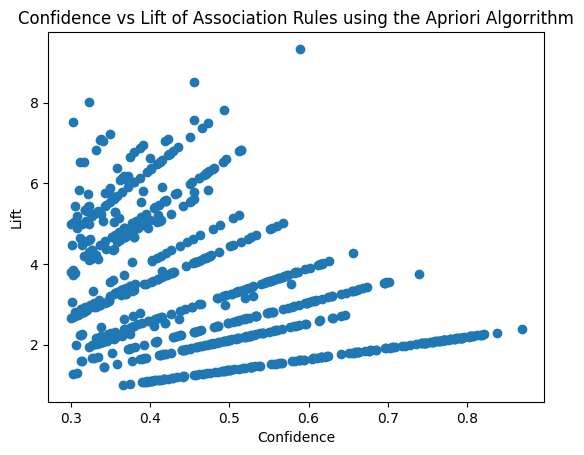

In [ ]:
# Visualize confidence vs lift
import matplotlib.pyplot as plt

# Scatter plot of confidence vs lift
plt.scatter(rules_apriori['confidence'], rules_apriori['lift'])
plt.title('Confidence vs Lift of Association Rules using the Apriori Algorrithm')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.show()

### FPGrowth Implementation 

In [9]:
import pandas as pd
import ast
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
from scipy.sparse import csr_matrix

# Path to the cleaned dataset
DATA_PATH = "../../data/cleaned_recipes.csv"

BATCH_SIZE = 50000  # Number of rows per batch

def load_and_preprocess_data():
    """
    Load and preprocess the dataset.
    """
    diet_data = pd.read_csv(DATA_PATH)
    # Convert 'RecipeIngredientParts' back to list
    diet_data["RecipeIngredientParts"] = diet_data["RecipeIngredientParts"].apply(ast.literal_eval)
    return diet_data

def process_batch(batch_data, te, min_support):
    """
    Process a batch of data to generate frequent itemsets.
    """
    transactions = batch_data["RecipeIngredientParts"].tolist()

    # Encode transactions using TransactionEncoder
    ingredient_matrix = te.fit_transform(transactions)

    # Convert to sparse matrix
    ingredient_sparse = csr_matrix(ingredient_matrix)

    # Convert sparse matrix to DataFrame
    ingredient_df = pd.DataFrame.sparse.from_spmatrix(ingredient_sparse, columns=te.columns_)

    # Generate frequent itemsets using fpgrowth
    frequent_itemsets = fpgrowth(ingredient_df, min_support=min_support, use_colnames=True)
    return frequent_itemsets

def generate_association_rules_in_batches(diet_data, min_support=0.01, min_confidence=0.3):
    """
    Generate association rules by processing data in batches.
    """
    te = TransactionEncoder()
    all_frequent_itemsets = []

    # Process the data in batches
    for start_idx in range(0, len(diet_data), BATCH_SIZE):
        batch_data = diet_data.iloc[start_idx:start_idx + BATCH_SIZE]
        frequent_itemsets = process_batch(batch_data, te, min_support)
        all_frequent_itemsets.append(frequent_itemsets)

    # Combine frequent itemsets from all batches
    all_frequent_itemsets = pd.concat(all_frequent_itemsets, ignore_index=True).drop_duplicates()

    # Generate association rules
    rules = association_rules(all_frequent_itemsets, metric="confidence", min_threshold=min_confidence,  num_itemsets=len(frequent_itemsets))

    # Convert antecedents and consequents to lists for easier processing
    rules["antecedents"] = rules["antecedents"].apply(lambda x: list(x))
    rules["consequents"] = rules["consequents"].apply(lambda x: list(x))

    return rules

def recommend_ingredients(rules, selected_ingredients):
    """
    Recommend additional ingredients based on selected ones.
    """
    matched_rules = rules[rules["antecedents"].apply(lambda x: set(selected_ingredients).issubset(set(x)))]

    if matched_rules.empty:
        return []

    recommendations = matched_rules[["consequents", "confidence"]]
    recommendations = recommendations.explode("consequents").groupby("consequents").mean().reset_index()
    recommendations = recommendations.sort_values(by="confidence", ascending=False)

    return recommendations.to_dict(orient="records")

def recommend_recipes_from_recommendations(diet_data, ingredient_recommendations, selected_ingredients, confidence_threshold=0.45, max_recipes=5):
    """
    Recommend recipes based on selected ingredients and additional recommendations with confidence > confidence_threshold,
    limiting the number of recommended recipes to max_recipes.
    """
    # Filter recommended ingredients with confidence > threshold
    high_confidence_ingredients = [
        item["consequents"] for item in ingredient_recommendations if item["confidence"] > confidence_threshold
    ]

    # Flatten the list of high-confidence ingredients
    additional_ingredients = []
    for sublist in high_confidence_ingredients:
        additional_ingredients.extend(sublist)

    # Combine selected ingredients with high-confidence ingredients
    combined_ingredients = selected_ingredients + additional_ingredients

    # Define a function to calculate ingredient match score
    def calculate_match_score(recipe_ingredients, combined_ingredients):
        recipe_set = set(recipe_ingredients)
        combined_set = set(combined_ingredients)
        return len(recipe_set.intersection(combined_set))

    # Calculate match scores for all recipes
    diet_data["MatchScore"] = diet_data["RecipeIngredientParts"].apply(
        lambda x: calculate_match_score(x, combined_ingredients)
    )

    # Filter and sort recipes by match score
    matching_recipes = diet_data[diet_data["MatchScore"] > 0].sort_values(by="MatchScore", ascending=False)

    # Limit to max_recipes
    top_recipes = matching_recipes.head(max_recipes)

    # Return the top recipes
    return top_recipes[["RecipeId", "Name", "Description", "CookTime", "TotalTime", "RecipeIngredientParts"]].to_dict(orient="records")

if __name__ == "__main__":
    # Step 1: Load the data
    diet_data = load_and_preprocess_data()

    # Step 2: Define selected ingredients
    selected_ingredients = ["flour", "milk"]  # Example selected ingredients

    # Step 3: Generate association rules using fpgrowth in batches
    rules = generate_association_rules_in_batches(diet_data)

    # Step 4: Generate ingredient recommendations
    ingredient_recommendations = recommend_ingredients(rules, selected_ingredients)

    # Step 5: Recommend recipes with max 5 results
    recommended_recipes = recommend_recipes_from_recommendations(
        diet_data,
        ingredient_recommendations,
        selected_ingredients,
        confidence_threshold=0.45,
        max_recipes=5
    )

    # Print the number of recommended recipes
    print(f"Number of Recommended Recipes: {len(recommended_recipes)}")

    # Print detailed recommended recipes
    print("Recommended Recipes:")
    for recipe in recommended_recipes:
        print(f"- {recipe['Name']} (Cook Time: {recipe['CookTime']} mins)")


C:\Users\User\AppData\Local\Temp\ipykernel_17488\143601028.py:34: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  ingredient_df = pd.DataFrame.sparse.from_spmatrix(ingredient_sparse, columns=te.columns_)
C:\Users\User\AppData\Local\Temp\ipykernel_17488\143601028.py:34: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  ingredient_df = pd.DataFrame.sparse.from_spmatrix(ingredient_sparse, columns=te.columns_)
C:\Users\User\AppData\Local\Temp\ipykernel_17488\143601028.py:34: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  ingredient_df = pd.DataFrame.sparse.from_spmatrix(ingredient_sparse, columns=te.columns_)
C:\Users\User\AppDa

Number of Recommended Recipes: 5
Recommended Recipes:
- 2-Hour Crescent Rolls (Cook Time: 10 mins)
- Warm Chicken A La King (Cook Time: 3 mins)
- Holiday Tea Cakes (Cook Time: 10 mins)
- Suzanne's Rolls (Cook Time: 20 mins)
- Chicken and Broccoli Lasagna (Cook Time: 55 mins)


### FPGrowth Association Rules Evaluation 

In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
from scipy.sparse import csr_matrix
import ast

# Path to the cleaned dataset
DATA_PATH = "../../data/cleaned_recipes.csv"
BATCH_SIZE = 50000  # Number of rows per batch

def load_and_preprocess_data():
    """
    Load and preprocess the dataset.
    """
    # Load the CSV file
    diet_data = pd.read_csv(DATA_PATH)
    # Convert 'RecipeIngredientParts' back to list format
    diet_data["RecipeIngredientParts"] = diet_data["RecipeIngredientParts"].apply(ast.literal_eval)
    return diet_data

def process_batch(batch_data, te, min_support):
    """
    Process a batch of data to generate frequent itemsets.
    """
    transactions = batch_data["RecipeIngredientParts"].tolist()

    # Encode transactions using TransactionEncoder
    ingredient_matrix = te.fit_transform(transactions)

    # Convert to sparse matrix
    ingredient_sparse = csr_matrix(ingredient_matrix)

    # Convert sparse matrix to DataFrame
    ingredient_df = pd.DataFrame.sparse.from_spmatrix(ingredient_sparse, columns=te.columns_)

    # Generate frequent itemsets using fpgrowth
    frequent_itemsets = fpgrowth(ingredient_df, min_support=min_support, use_colnames=True)
    return frequent_itemsets

def evaluate_fpgrowth_in_batches(diet_data, min_support=0.01, min_confidence=0.3, min_lift=1.0, min_conviction=1.0):
    """
    Evaluate association rules using FP-Growth algorithm in batches.
    """
    te = TransactionEncoder()
    all_frequent_itemsets = []

    # Process the data in batches
    for start_idx in range(0, len(diet_data), BATCH_SIZE):
        batch_data = diet_data.iloc[start_idx:start_idx + BATCH_SIZE]
        frequent_itemsets = process_batch(batch_data, te, min_support)
        all_frequent_itemsets.append(frequent_itemsets)

    # Combine frequent itemsets from all batches
    all_frequent_itemsets = pd.concat(all_frequent_itemsets, ignore_index=True).drop_duplicates()

    # Generate association rules
    rules = association_rules(all_frequent_itemsets, metric="confidence", min_threshold=min_confidence , num_itemsets=len(frequent_itemsets))

    # Filter rules by additional metrics like Lift and Conviction
    rules = rules[(rules['lift'] >= min_lift) & (rules['conviction'] >= min_conviction)]

    return rules

# Example usage
diet_data = load_and_preprocess_data()  # Load your dataset

# Evaluate association rules with desired thresholds
rules_fpgrowth = evaluate_fpgrowth_in_batches(diet_data, min_support=0.01, min_confidence=0.3, min_lift=1.0, min_conviction=1.0)

# Display the evaluated rules
print(f"Number of Association Rules: {len(rules_fpgrowth)}")
rules_fpgrowth[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'conviction']]

# Display the evaluated rules
print(f"Number of Association Rules: {len(rules_fpgrowth)}")
rules_fpgrowth[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'conviction']]
avg_support_fpgrowth = rules_fpgrowth['support'].mean()
avg_confidence_fpgrowth = rules_fpgrowth['confidence'].mean()
avg_lift_fpgrowth = rules_fpgrowth['lift'].mean()



# Scatter plot of confidence vs lift
plt.scatter(rules['confidence'], rules['lift'])
plt.title('Confidence vs Lift of Association Rules using the FPGrowth Algorrithm')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.show()


C:\Users\mrmte\AppData\Local\Temp\ipykernel_15552\2847760901.py:34: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  ingredient_df = pd.DataFrame.sparse.from_spmatrix(ingredient_sparse, columns=te.columns_)
C:\Users\mrmte\AppData\Local\Temp\ipykernel_15552\2847760901.py:34: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  ingredient_df = pd.DataFrame.sparse.from_spmatrix(ingredient_sparse, columns=te.columns_)
C:\Users\mrmte\AppData\Local\Temp\ipykernel_15552\2847760901.py:34: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  ingredient_df = pd.DataFrame.sparse.from_spmatrix(ingredient_sparse, columns=te.columns_)
C:\Users\mrmt

Number of Association Rules: 1305


NameError: name 'rules' is not defined

#### Note : 

FP-Growth seems to outperform Apriori in terms of the number of rules generated, confidence, lift, and conviction. This indicates that FP-Growth tends to produce more significant, reliable, and stronger rules.